In [51]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from random import randint



def ReadFemResp(dct_file='2002FemResp.dct',
                dat_file='2002FemResp.dat.gz',
                nrows=None):
    """Reads the NSFG respondent data.

    dct_file: string file name
    dat_file: string file name

    returns: DataFrame
    """
    dct = thinkstats2.ReadStataDct(dct_file)
    df = dct.ReadFixedWidth(dat_file, compression='gzip', nrows=nrows)
    CleanFemResp(df)
    return df


def CleanFemResp(df):
    """Recodes variables from the respondent frame.

    df: DataFrame
    """
    pass


def ReadFemPreg(dct_file='2002FemPreg.dct',
                dat_file='2002FemPreg.dat.gz'):
    """Reads the NSFG pregnancy data.

    dct_file: string file name
    dat_file: string file name

    returns: DataFrame
    """
    dct = thinkstats2.ReadStataDct(dct_file)
    df = dct.ReadFixedWidth(dat_file, compression='gzip')
    CleanFemPreg(df)
    return df


def CleanFemPreg(df):
    """Recodes variables from the pregnancy frame.

    df: DataFrame
    """
    # mother's age is encoded in centiyears; convert to years
    df.agepreg /= 100.0

    # birthwgt_lb contains at least one bogus value (51 lbs)
    # replace with NaN
    df.loc[df.birthwgt_lb > 20, 'birthwgt_lb'] = np.nan
    
    # replace 'not ascertained', 'refused', 'don't know' with NaN
    na_vals = [97, 98, 99]
    df.birthwgt_lb.replace(na_vals, np.nan, inplace=True)
    df.birthwgt_oz.replace(na_vals, np.nan, inplace=True)
    df.hpagelb.replace(na_vals, np.nan, inplace=True)

    df.babysex.replace([7, 9], np.nan, inplace=True)
    df.nbrnaliv.replace([9], np.nan, inplace=True)

    # birthweight is stored in two columns, lbs and oz.
    # convert to a single column in lb
    # NOTE: creating a new column requires dictionary syntax,
    # not attribute assignment (like df.totalwgt_lb)
    df['totalwgt_lb'] = df.birthwgt_lb + df.birthwgt_oz / 16.0    

    # due to a bug in ReadStataDct, the last variable gets clipped;
    # so for now set it to NaN
    df.cmintvw = np.nan


def ValidatePregnum(resp, preg):
    """Validate pregnum in the respondent file.

    resp: respondent DataFrame
    preg: pregnancy DataFrame
    """
    # make the map from caseid to list of pregnancy indices
    preg_map = MakePregMap(preg)
    
    # iterate through the respondent pregnum series
    for index, pregnum in resp.pregnum.iteritems():
        caseid = resp.caseid[index]
        indices = preg_map[caseid]

        # check that pregnum from the respondent file equals
        # the number of records in the pregnancy file
        if len(indices) != pregnum:
            print(caseid, len(indices), pregnum)
            return False

    return True


def MakePregMap(df):
    """Make a map from caseid to list of preg indices.

    df: DataFrame

    returns: dict that maps from caseid to list of indices into `preg`
    """
    d = defaultdict(list)
    for index, caseid in df.caseid.iteritems():
        d[caseid].append(index)
    return d


def main():
    """Tests the functions in this module.

    script: string script name
    """
    # read and validate the respondent file
    resp = ReadFemResp()

    assert(len(resp) == 7643)
    assert(resp.pregnum.value_counts()[1] == 1267)

    # read and validate the pregnancy file
    preg = ReadFemPreg()
    print(preg.shape)

    assert len(preg) == 13593
    assert preg.caseid[13592] == 12571
    assert preg.pregordr.value_counts()[1] == 5033
    assert preg.nbrnaliv.value_counts()[1] == 8981
    assert preg.babysex.value_counts()[1] == 4641
    assert preg.birthwgt_lb.value_counts()[7] == 3049
    assert preg.birthwgt_oz.value_counts()[0] == 1037
    assert preg.prglngth.value_counts()[39] == 4744
    assert preg.outcome.value_counts()[1] == 9148
    assert preg.birthord.value_counts()[1] == 4413
    assert preg.agepreg.value_counts()[22.75] == 100
    assert preg.totalwgt_lb.value_counts()[7.5] == 302

    weights = preg.finalwgt.value_counts()
    key = max(weights.keys())
    assert preg.finalwgt.value_counts()[key] == 6

    # validate that the pregnum column in `resp` matches the number
    # of entries in `preg`
    assert(ValidatePregnum(resp, preg))

    
    print('All tests passed.')


In [52]:
data = []
for i in range(3400):
    data.append(np.round(np.random.randint(1,100)/100*np.random.randint(1,100)))

In [53]:
data_count = {}
for key in data:
    data_count[key] = data_count.get(key,0) + 1

(array([4., 4., 4., 4., 4., 4., 4., 4., 3., 4., 4., 4., 4., 4., 4., 4., 3.,
        4., 4., 4., 4., 4., 4., 4., 3.]),
 array([ 0.  ,  3.88,  7.76, 11.64, 15.52, 19.4 , 23.28, 27.16, 31.04,
        34.92, 38.8 , 42.68, 46.56, 50.44, 54.32, 58.2 , 62.08, 65.96,
        69.84, 73.72, 77.6 , 81.48, 85.36, 89.24, 93.12, 97.  ]),
 <BarContainer object of 25 artists>)

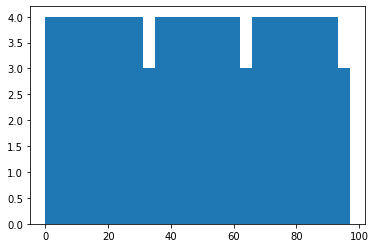

In [54]:
plt.hist(data_count, bins=25)

In [63]:
data = pd.read_csv("pregnancy_data.csv")
list_of_req_columns = [
    'caseid',
    'prglngth',
    'outcome',
    'pregordr',
    'birthord',
    'birthwgt_lb',
    'birthwgt_oz',
    'agepreg',
    'finalwgt'
]
CleanFemPreg(data)
data = data[list_of_req_columns]

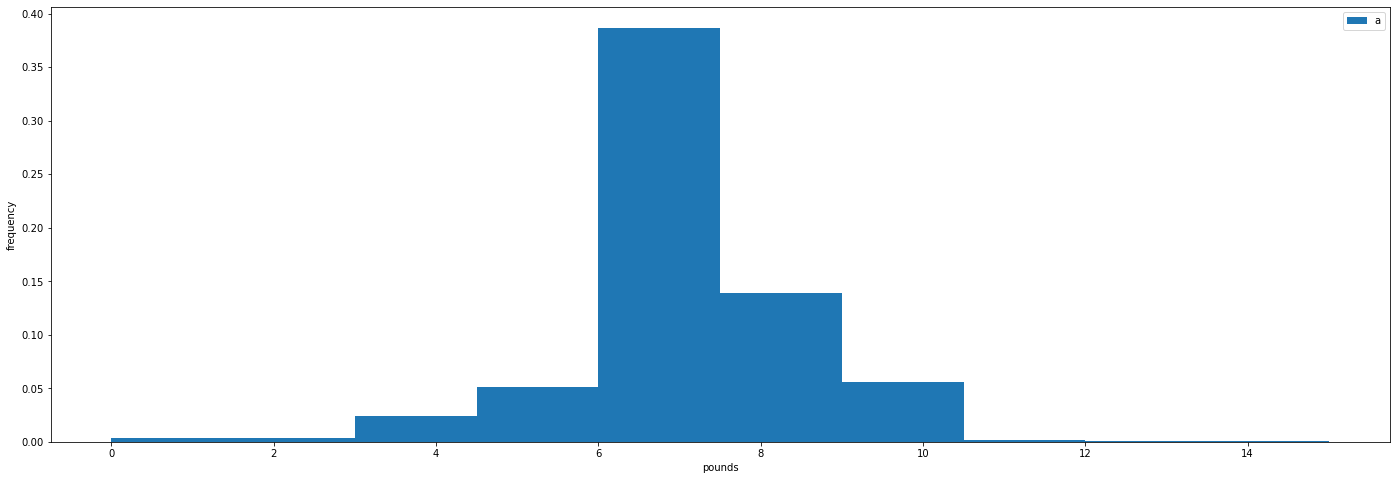

<class 'numpy.ndarray'>


In [92]:
live_data = data
# [data.outcome == 1]
plt.figure(figsize=(24,8))
a,b,c = plt.hist(live_data.birthwgt_lb, density=2)
plt.xlabel('pounds')
plt.ylabel('frequency')
plt.legend('a')
plt.show()

[6.0, 7.5, 9.0, 4.5, 3.0, 1.5, 0.0, 10.5, 12.0, 13.5]

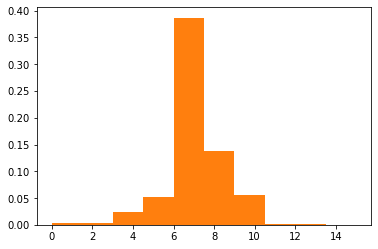

In [123]:
def mode(hist_var):
    a,b,c = hist_var
    data = {}
    for i in range(len(a)):
        data[a[i]] = b[i]
    return data[a.max()]
def modeAll(hist_var):
    a,b,c = hist_var
    data = {}
    for i in range(len(a)):
        data[a[i]] = b[i]
    a.sort()
    a = np.flip(a)
    return [data[i] for i in a]
mode(plt.hist(live_data.birthwgt_lb, density=2))

modeAll(plt.hist(live_data.birthwgt_lb, density=2))